**Install W&B, fetching dataset**

In [1]:
%%capture
!pip install wandb --upgrade

# workaround to fetch MNIST data
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

**W&B login**

In [2]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
sweep_config = {
    'method': 'random'
    }

In [4]:
metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

In [5]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [128, 256, 512]
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

In [6]:
parameters_dict.update({
    'epochs': {
        'value': 1}
    })

In [7]:
import math

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms 
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(32),
        'max': math.log(256),
      }
    })

In [8]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform',
                               'max': 5.545177444479562,
                               'min': 3.4657359027997265,
                               'q': 1},
                'dropout': {'values': [0.3, 0.4, 0.5]},
                'epochs': {'value': 1},
                'fc_layer_size': {'values': [128, 256, 512]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['adam', 'sgd']}}}


**Initialize the Sweep**

In [9]:
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps")

Create sweep with ID: wv795kai
Sweep URL: https://wandb.ai/nsp_team/pytorch-sweeps-demo/sweeps/wv795kai


**Running sweep agent**

In [10]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        loader = build_dataset(config.batch_size)
        network = build_network(config.fc_layer_size, config.dropout)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate)

        for epoch in range(config.epochs):
            avg_loss = train_epoch(network, loader, optimizer)
            wandb.log({"loss": avg_loss, "epoch": epoch})           

In [11]:
def build_dataset(batch_size):
   
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))])
    # download MNIST training dataset
    dataset = datasets.MNIST(".", train=True, download=True,
                             transform=transform)
    sub_dataset = torch.utils.data.Subset(
        dataset, indices=range(0, len(dataset), 5))
    loader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size)

    return loader


def build_network(fc_layer_size, dropout):
    network = nn.Sequential(  # fully-connected, single hidden layer
        nn.Flatten(),
        nn.Linear(784, fc_layer_size), nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(fc_layer_size, 10),
        nn.LogSoftmax(dim=1))

    return network.to(device)
        

def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer


def train_epoch(network, loader, optimizer):
    cumu_loss = 0
    for _, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # ➡ Forward pass
        loss = F.nll_loss(network(data), target)
        cumu_loss += loss.item()

        # ⬅ Backward pass + weight update
        loss.backward()
        optimizer.step()

        wandb.log({"batch loss": loss.item()})

    return cumu_loss / len(loader)

In [12]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: yckrk9hh with config:
wandb: 	batch_size: 36
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.04656181376209363
wandb: 	optimizer: adam
wandb: Currently logged in as: nsp_team (use `wandb login --relogin` to force relogin)


batch loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,1.65317
epoch,0
loss,2.48699


wandb: Agent Starting Run: ue35o2ap with config:
wandb: 	batch_size: 147
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.09668133350447876
wandb: 	optimizer: adam


batch loss,▁██▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,1.40475
epoch,0
loss,14.68168


wandb: Agent Starting Run: i8yhicg2 with config:
wandb: 	batch_size: 166
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.022960793011946617
wandb: 	optimizer: adam


batch loss,▃██▄▃▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.3133
epoch,0
loss,1.27264


wandb: Agent Starting Run: lc2g8kdz with config:
wandb: 	batch_size: 51
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.06848139363265486
wandb: 	optimizer: adam


batch loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,1.12794
epoch,0
loss,3.2117


wandb: Agent Starting Run: w04wrue2 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.019651831714580105
wandb: 	optimizer: sgd


batch loss,██▇▅▄▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▂▂▂▂▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.35761
epoch,0
loss,0.60952


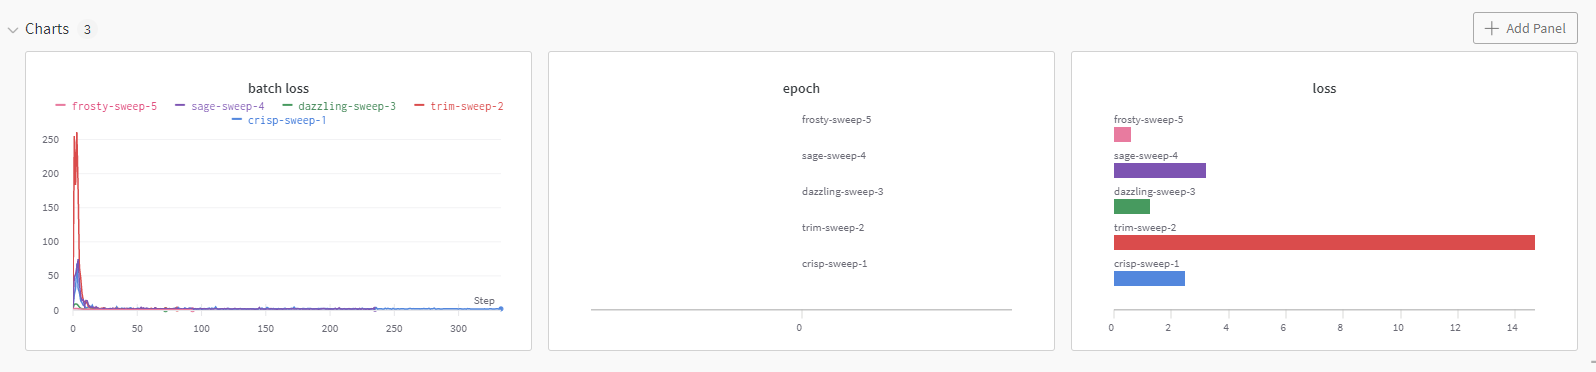